In [ ]:
#Always activate the environment before running this notebook!
#cd /Users/glusker/Documents/courses/CAS_ADS/Module6/M6project
#source venv/bin/activate

Imprt libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display,clear_output
from warnings import filterwarnings
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

Data preparation

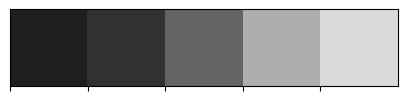

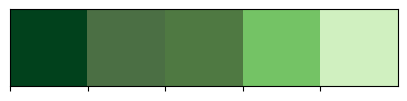

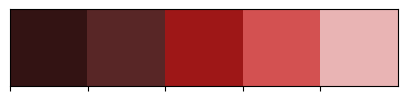

In [2]:
#Color definition for images
colors_dark = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']
colors_red = ["#331313", "#582626", '#9E1717', '#D35151', '#E9B4B4']
colors_green = ['#01411C','#4B6F44','#4F7942','#74C365','#D0F0C0']

sns.palplot(colors_dark)
sns.palplot(colors_green)
sns.palplot(colors_red)

In [29]:
#Introducing labels in the dataset

dataset_path = "/Users/glusker/Documents/courses/CAS_ADS/Module6/M6project/Training"
labels = ['glioma_tumor', 'no_tumor', 'meningioma_tumor', 'pituitary_tumor']

Loading training dataset

In [37]:
import os
import cv2
import numpy as np
from tqdm import tqdm
from collections import Counter

# Paths
train_dir = "/Users/glusker/Documents/courses/CAS_ADS/Module6/M6project/Training"

# Initialize lists
X_train = []
y_train = []

# Load original images
labels = ["glioma_tumor", "no_tumor", "meningioma_tumor", "pituitary_tumor"]
for label in labels:
    folder_path = os.path.join(train_dir, label)
    for filename in tqdm(os.listdir(folder_path), desc=f"Loading {label}"):
        img_path = os.path.join(folder_path, filename)
        img = cv2.imread(img_path)
        if img is not None:
            X_train.append(img)
            y_train.append(label)

# Convert to NumPy arrays but keep lists to avoid dimension issues
X_train = np.array(X_train, dtype=object)
y_train = np.array(y_train)

# Count class distribution
class_counts = Counter(y_train)

print(f"Loaded {X_train.shape[0]} images from the Training dataset.")
print("Class distribution before augmentation:")
for label, count in class_counts.items():
    print(f"{label}: {count} images")


Loading pituitary_tumor: 100%|██████████| 827/827 [00:00<00:00, 1018.62it/s]

Loaded 2870 images from the Training dataset.
Class distribution before augmentation:
glioma_tumor: 826 images
no_tumor: 395 images
meningioma_tumor: 822 images
pituitary_tumor: 827 images


In [38]:
from collections import Counter

# Count current images before augmentation
class_counts = Counter(y_train)

print("Class distribution before augmentation:")
for label, count in class_counts.items():
    print(f"{label}: {count} images")


Class distribution before augmentation:
glioma_tumor: 826 images
no_tumor: 395 images
meningioma_tumor: 822 images
pituitary_tumor: 827 images


In [44]:
import os
import cv2
import numpy as np
from tqdm import tqdm
import albumentations as A
from collections import Counter

# Paths
train_dir = "/Users/glusker/Documents/courses/CAS_ADS/Module6/M6project/Training"
augmented_train_dir = "/Users/glusker/Documents/courses/CAS_ADS/Module6/M6project/Training_augmented_NB2"

# Define augmentation pipeline
augmentation = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.Rotate(limit=10, p=0.5),
])

# Define classes to augment
labels = ["glioma_tumor", "no_tumor", "meningioma_tumor", "pituitary_tumor"]

# Ensure output directories exist
os.makedirs(augmented_train_dir, exist_ok=True)

for label in labels:
    class_dir = os.path.join(train_dir, label)
    augmented_class_dir = os.path.join(augmented_train_dir, label)

    os.makedirs(augmented_class_dir, exist_ok=True)

    # Load all images from the class
    image_files = [f for f in os.listdir(class_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]
    num_original = len(image_files)

    # Determine how many images to generate
    target_count = 2400
    num_to_generate = target_count - num_original

    # Copy original images first
    for filename in tqdm(image_files, desc=f"Copying {label}"):
        img_path = os.path.join(class_dir, filename)
        img = cv2.imread(img_path)
        if img is not None:
            save_path = os.path.join(augmented_class_dir, filename)
            cv2.imwrite(save_path, img)

    # Augment only if needed
    if num_to_generate > 0:
        for i in tqdm(range(num_to_generate), desc=f"Generating for {label}"):
            img_path = os.path.join(class_dir, image_files[i % num_original])  # Cycle through original images
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert for augmentation
                augmented = augmentation(image=img)["image"]
                save_path = os.path.join(augmented_class_dir, f"{label}_aug_{i+1}.png")
                cv2.imwrite(save_path, cv2.cvtColor(augmented, cv2.COLOR_RGB2BGR))

print("Augmentation complete. No_tumor_augmented was **excluded**.")


Generating for pituitary_tumor: 100%|██████████| 1573/1573 [00:09<00:00, 167.41it/s]

Augmentation complete. No_tumor_augmented was **excluded**.


In [45]:
import os

# Path to augmented dataset
augmented_train_dir = "/Users/glusker/Documents/courses/CAS_ADS/Module6/M6project/Training_augmented_NB2"

# Count images per class
final_counts = {label: len(os.listdir(os.path.join(augmented_train_dir, label))) for label in ["glioma_tumor", "no_tumor", "meningioma_tumor", "pituitary_tumor"]}

print("Final dataset distribution after balanced augmentation:")
for label, count in final_counts.items():
    print(f"{label}: {count} images")


Final dataset distribution after balanced augmentation:
glioma_tumor: 2400 images
no_tumor: 2400 images
meningioma_tumor: 2400 images
pituitary_tumor: 2400 images


Data preprocessing
Yes, contrast-focused augmentation is the priority, especially for "no_tumor" vs "meningioma", since they are visually similar.

Plan for Augmentation:
For "no_tumor" (Heavy Augmentation)

Contrast adjustment (CLAHE)
Brightness shifts
Horizontal & vertical flips
Rotation (±15°)
Zoom (random crop)
Add Gaussian noise
For Other Classes (Light Augmentation)

Small rotations (±10°)
Horizontal flips
Slight brightness adjustments

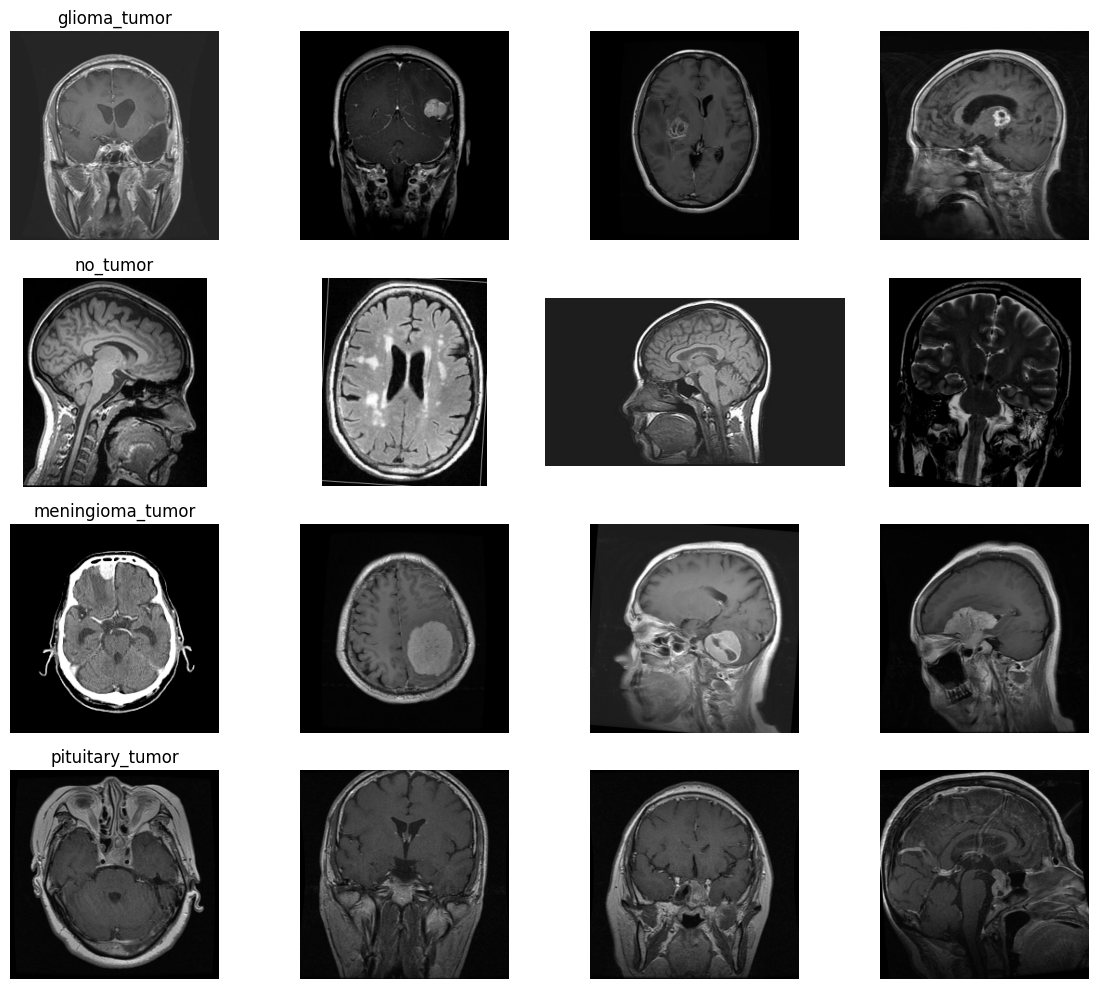

In [46]:
import matplotlib.pyplot as plt
import random
import cv2
import os

# Define path to augmented dataset
augmented_train_dir = "/Users/glusker/Documents/courses/CAS_ADS/Module6/M6project/Training_augmented_NB2"

# Define class labels
labels = ["glioma_tumor", "no_tumor", "meningioma_tumor", "pituitary_tumor"]

# Number of images to display per class
num_images = 4  

# Display images
fig, axes = plt.subplots(len(labels), num_images, figsize=(12, 10))

for i, label in enumerate(labels):
    class_dir = os.path.join(augmented_train_dir, label)
    image_files = [f for f in os.listdir(class_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]

    # Select random images
    selected_files = random.sample(image_files, num_images)

    for j, file in enumerate(selected_files):
        img_path = os.path.join(class_dir, file)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB

        axes[i, j].imshow(img)
        axes[i, j].axis("off")
        if j == 0:
            axes[i, j].set_title(label, fontsize=12)

plt.tight_layout()
plt.show()


In [48]:
from collections import Counter

print("Final label distribution after augmentation:", Counter(y_train_augmented))


Final label distribution after augmentation: Counter({'no_tumor': 2481, 'pituitary_tumor': 2481, 'glioma_tumor': 2478, 'meningioma_tumor': 2466})


In [54]:
import os
import cv2
import numpy as np
from tqdm import tqdm
from collections import Counter

# Paths
augmented_train_dir = "/Users/glusker/Documents/courses/CAS_ADS/Module6/M6project/Training_augmented_NB2"

# Initialize lists
X_train_augmented = []
y_train_augmented = []

# Define class labels
labels = ["glioma_tumor", "no_tumor", "meningioma_tumor", "pituitary_tumor"]

# Load images from the augmented dataset
for label in labels:
    folder_path = os.path.join(augmented_train_dir, label)
    image_files = sorted([f for f in os.listdir(folder_path) if f.endswith(('.png', '.jpg', '.jpeg'))])

    if len(image_files) != 2400:
        print(f"Warning: {label} has {len(image_files)} images instead of 2400!")

    for filename in tqdm(image_files, desc=f"Loading {label}"):
        img_path = os.path.join(folder_path, filename)
        img = cv2.imread(img_path)
        if img is not None:
            X_train_augmented.append(img)
            y_train_augmented.append(label)

# Convert lists to NumPy arrays
X_train_augmented = np.array(X_train_augmented, dtype=object)
y_train_augmented = np.array(y_train_augmented)

# Count class distribution
class_counts = Counter(y_train_augmented)

print(f"Final dataset size after reloading: {X_train_augmented.shape[0]} images")
print("Class distribution after reloading:")
for label, count in class_counts.items():
    print(f"{label}: {count} images")


Loading pituitary_tumor: 100%|██████████| 2400/2400 [00:07<00:00, 327.63it/s]

Final dataset size after reloading: 9600 images
Class distribution after reloading:
glioma_tumor: 2400 images
no_tumor: 2400 images
meningioma_tumor: 2400 images
pituitary_tumor: 2400 images


In [55]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Encode class labels as integers
label_encoder = LabelEncoder()
y_train_aug_encoded = label_encoder.fit_transform(y_train_augmented)  # Convert labels to integers

# One-hot encode labels
y_train_aug_one_hot = to_categorical(y_train_aug_encoded, num_classes=4)

# Print class mapping
print("Label Encoding Mapping:", dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))


Label Encoding Mapping: {'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}


In [56]:
# Ensure all images are valid NumPy arrays before resizing
X_train_resized = np.array([cv2.resize(np.array(img, dtype=np.uint8), (150, 150)) for img in X_train_augmented], dtype=np.uint8)

# Confirm new shape
print("Resized dataset shape:", X_train_resized.shape)


Resized dataset shape: (9600, 150, 150, 3)


In [57]:
import os

augmented_train_dir = "/Users/glusker/Documents/courses/CAS_ADS/Module6/M6project/Training_augmented_NB2"

for label in ["glioma_tumor", "no_tumor", "meningioma_tumor", "pituitary_tumor"]:
    class_dir = os.path.join(augmented_train_dir, label)
    print(f"{label}: {len(os.listdir(class_dir))} images")


glioma_tumor: 2400 images
no_tumor: 2400 images
meningioma_tumor: 2400 images
pituitary_tumor: 2400 images


In [53]:
import os

augmented_train_dir = "/Users/glusker/Documents/courses/CAS_ADS/Module6/M6project/Training_augmented_NB2"

for label in ["glioma_tumor", "no_tumor", "meningioma_tumor", "pituitary_tumor"]:
    class_dir = os.path.join(augmented_train_dir, label)
    unique_files = set(os.listdir(class_dir))
    print(f"{label}: {len(unique_files)} unique images")


glioma_tumor: 2400 unique images
no_tumor: 2400 unique images
meningioma_tumor: 2400 unique images
pituitary_tumor: 2400 unique images


In [59]:
from collections import Counter

# Verify encoded label distribution
print("Final label distribution after encoding:", Counter(y_train_aug_encoded))


Final label distribution after encoding: Counter({0: 2400, 2: 2400, 1: 2400, 3: 2400})
